# Residency Program Decision Tree Simulation

This decision tree is used to choose students who will be interviewed for matching with the ENT residency program

There are nine features considered:

1. Students who rotated with the program
2. URM (yes/no)
3. Preference given for program (yes/no)
4. USMLE score(s) -- this is STEP1 and STEP2
5. Medical school reputation (US News rank)
6. Research
7. Class rank
8. Letters of recommendation
9. Leadership/other exceptional characteristics

Based on a decision tree, applicants are separated into group A and group B, of which (mostly?) the top group A applicants are interviewed after being sorted based on the quality of their letters, scores, research, and intangibles.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
def sample_rotation(n):
    """
    Sample whether applicants rotated with the UW program
    (needs to be updated to reflect real numbers)
    
    Parameters
    -----------
    n: number of samples
    
    Returns
    -----------
    n samples from a bernoulli distribution with p = 0.05
    """
    return np.random.binomial(1,0.05,n)

def sample_urm(n):
    """
    Sample whether applicants are underrepresented/minorities
    Taken from https://www.aamc.org/news-insights/medical-school-applicants-and-enrollments-hit-record-highs-underrepresented-minorities-lead-surge
    Black/Hispanic applicants account for ~24% of all applicants
    
    Parameters
    -----------
    n: number of samples
    
    Returns
    -----------
    n samples from a bernoulli distribution with p = 0.24
    """
    return np.random.binomial(1,0.24,n)

def sample_preference(n):
    """
    Sample whether applicants indicated that they preferred the program
    (needs to be updated with accurate numbers)
    
    Parameters
    -----------
    n: number of samples
    
    Returns
    -----------
    n samples from a bernoulli distribution with p = 0.1
    """
    return np.random.binomial(1,0.1,n)

def sample_step_1(n):
    """
    Sample whether applicants passed STEP 1
    Taken from https://www.usmle.org/sites/default/files/2022-05/USMLE%20Step%20Examination%20Score%20Interpretation%20Guidelines_5_24_22_0.pdf
    
    Parameters
    -----------
    n: number of samples
    
    Returns
    -----------
    n samples from a bernoulli distribution with p = 0.95
    """
    return np.random.binomial(1,0.95,n)

def sample_step_2(n):
    """
    Sample STEP 2 scores
    Distribution from https://www.usmle.org/sites/default/files/2022-05/USMLE%20Step%20Examination%20Score%20Interpretation%20Guidelines_5_24_22_0.pdf
    
    Parameters
    -----------
    n: number of samples
    
    Returns
    -----------
    n samples from a custom distribution which matches the distribution given by USMLE
    """
    low = 155
    high = 300
    scores = np.arange(low,high,5)
    pctl = np.array([0,0.2,0.4,0.7,1,1.3,1.6,2,3,5,8,12,17,23,31,40,50,60,71,81,89,95,98,98.4,98.7,99,99.3,99.6,99.9,100])
    pr = np.array([pctl[i+1]-pctl[i] for i in range(len(pctl)-1)])
    pr = pr/sum(pr)
    step2_dist = stats.rv_discrete(a=0,b=300,name='step2_dist', values=(scores, pr))
    return step2_dist.rvs(size=n)

def sample_class_rank(n):
    """
    Sample class ranks of applicants
    (needs to be updated to reflect real applicants)
    
    Parameters
    -----------
    n: number of samples
    
    Returns
    -----------
    n samples from a binomial distribution with 3 trials each with p=0.6
    """
    return np.random.binomial(3,0.6,n)

def sample_school_rank(n):
    """
    Sample medical school rankings of applicants
    (needs to be updated to reflect real applicants)
    
    Parameters
    -----------
    n: number of samples
    
    Returns
    -----------
    n samples from a binomial distribution with 5 trials each with p=0.5
    """
    return np.random.binomial(5,0.5,n)

def sample_research(n):
    """
    Sample research rating of applicants
    (needs to be updated to reflect real applicants)
    
    Parameters
    -----------
    n: number of samples
    
    Returns
    -----------
    n samples from a binomial distribution with 5 trials each with p=0.5
    """
    return np.random.binomial(5,0.5,n)

def sample_recommendation(n):
    """
    Sample recommendation letter ratings of applicants
    (needs to be updated to reflect real applicants)
    
    Parameters
    -----------
    n: number of samples
    
    Returns
    -----------
    n samples from a binomial distribution with 5 trials each with p=0.5
    """
    return np.random.binomial(5,0.5,n)

def sample_leadership(n):
    """
    Sample leadership or other exceptional characteristic ratings of applicants
    (needs to be updated to reflect real applicants)
    
    Parameters
    -----------
    n: number of samples
    
    Returns
    -----------
    n samples from a binomial distribution with 5 trials each with p=0.5
    """
    return np.random.binomial(5,0.5,n)

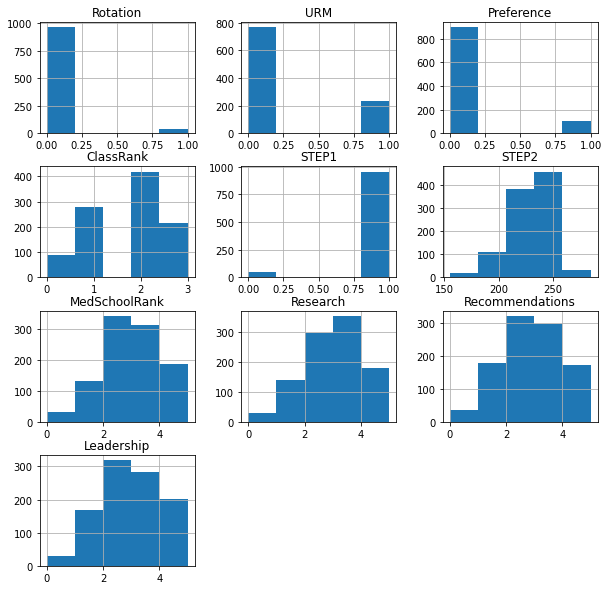

In [3]:
N = 1000

applications = pd.DataFrame({'Rotation':sample_rotation(N), 'URM':sample_urm(N),
                             'Preference':sample_preference(N), 'ClassRank':sample_class_rank(N),
                             'STEP1':sample_step_1(N), 'STEP2':sample_step_2(N),
                             'MedSchoolRank':sample_school_rank(N), 'Research':sample_research(N),
                             'Recommendations':sample_recommendation(N), 'Leadership':sample_leadership(N)})

applications.hist(figsize=(10,10), bins=5)
plt.show()

In [4]:
def residency_decision_tree(applications_df, 
                            t_score=240, t_school_rank=4,
                            t_class_rank=4, t_research=4,
                            t_recommendations=4, t_leadership=4,
                            t_exceptional_features=2):
    def exceptional_features(app):
        """
        Count and return number of exceptional features in an application

        Parameters
        -----------
        app: an application in the form of a row of a dataframe

        Returns
        -----------
        ex_feat: number of exceptional features in the application
        """
        ex_feat = 0
        if app.STEP1==1 and app.STEP2>=t_score: ex_feat+=1
        if app.MedSchoolRank>=t_school_rank: ex_feat+=1
        if app.ClassRank>=t_class_rank: ex_feat+=1
        if app.Research>=t_research: ex_feat+=1
        if app.Recommendations>=t_recommendations: ex_feat+=1
        if app.Leadership>=t_leadership: ex_feat+=1
        return ex_feat
        
    applications = applications_df.copy()
    applications['ExceptionalFeatures'] = applications.apply(lambda row: exceptional_features(row), axis=1)
    
    group_a = set()
    group_b = set()
    remaining = set(applications.index.tolist())
    
    # Add applicants who rotated with UW, are URM, or prefer the program to Group A
    rot = set(applications.index[applications.Rotation==1].tolist())
    urm = set(applications.index[applications.URM==1].tolist())
    pref = set(applications.index[applications.Preference==1].tolist())
    A = rot|urm|pref
    
    group_a |= A
    remaining -= A
    
    # Add high scorers on STEP 1 and 2 with multiple other exceptional features to Group A
    # high scorers with no other exceptional features are sent to Group B
    remaining_apps = applications.iloc[sorted(remaining)]
    for i,row in remaining_apps.iterrows():
        if row.STEP1==1 and row.STEP2>=t_score:
            if row.ExceptionalFeatures>=t_exceptional_features:
                remaining.remove(i)
                group_a.add(i)
            else:
                remaining.remove(i)
                group_b.add(i)
                
    # Add applicants from highly rated medical schools with multiple other exceptional features to Group A
    # applicants from good schools with no other exceptional features are sent to Group B
    remaining_apps = applications.iloc[sorted(remaining)]
    for i,row in remaining_apps.iterrows():
        if row.MedSchoolRank>=t_school_rank:
            if row.ExceptionalFeatures>=t_exceptional_features:
                remaining.remove(i)
                group_a.add(i)
            else:
                remaining.remove(i)
                group_b.add(i)
    
    # Add applicants with exceptional research resumes and other exceptional features to Group A
    # Good researchers with no other exceptional features are sent to Group B
    remaining_apps = applications.iloc[sorted(remaining)]
    for i,row in remaining_apps.iterrows():
        if row.Research>=t_research:
            if row.ExceptionalFeatures>=t_exceptional_features:
                remaining.remove(i)
                group_a.add(i)
            else:
                remaining.remove(i)
                group_b.add(i)
                
    # Add applicants who ranked highly in their class and have other exceptional features to Group A
    # applicants with high class rankings and no other exceptional features are sent to Group B
    remaining_apps = applications.iloc[sorted(remaining)]
    for i,row in remaining_apps.iterrows():
        if row.ClassRank>=t_class_rank:
            if row.ExceptionalFeatures>=t_exceptional_features:
                remaining.remove(i)
                group_a.add(i)
            else:
                remaining.remove(i)
                group_b.add(i)
                
    # Remaining Applicants are sent to Group B
    group_b |= remaining
    
    return sorted(group_a),sorted(group_b)

In [5]:
group_a,group_b = residency_decision_tree(applications)
applications['GroupA'] = 0
applications['GroupA'].iloc[group_a] = 1
applications

,Rotation,URM,Preference,ClassRank,STEP1,STEP2,MedSchoolRank,Research,Recommendations,Leadership,GroupA
0,0,0,0,1,1,240,2,2,3,3,0
1,0,0,0,3,1,250,2,3,4,4,1
2,0,0,0,2,1,245,4,2,1,3,1
3,0,0,0,1,1,255,4,3,3,3,1
4,0,1,0,0,1,235,3,2,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,2,1,230,2,4,4,4,1
996,0,0,1,1,1,195,2,2,2,3,1
997,0,0,0,0,1,210,2,2,3,4,0
998,0,1,0,1,1,255,2,4,2,1,1


<Figure size 432x288 with 0 Axes>

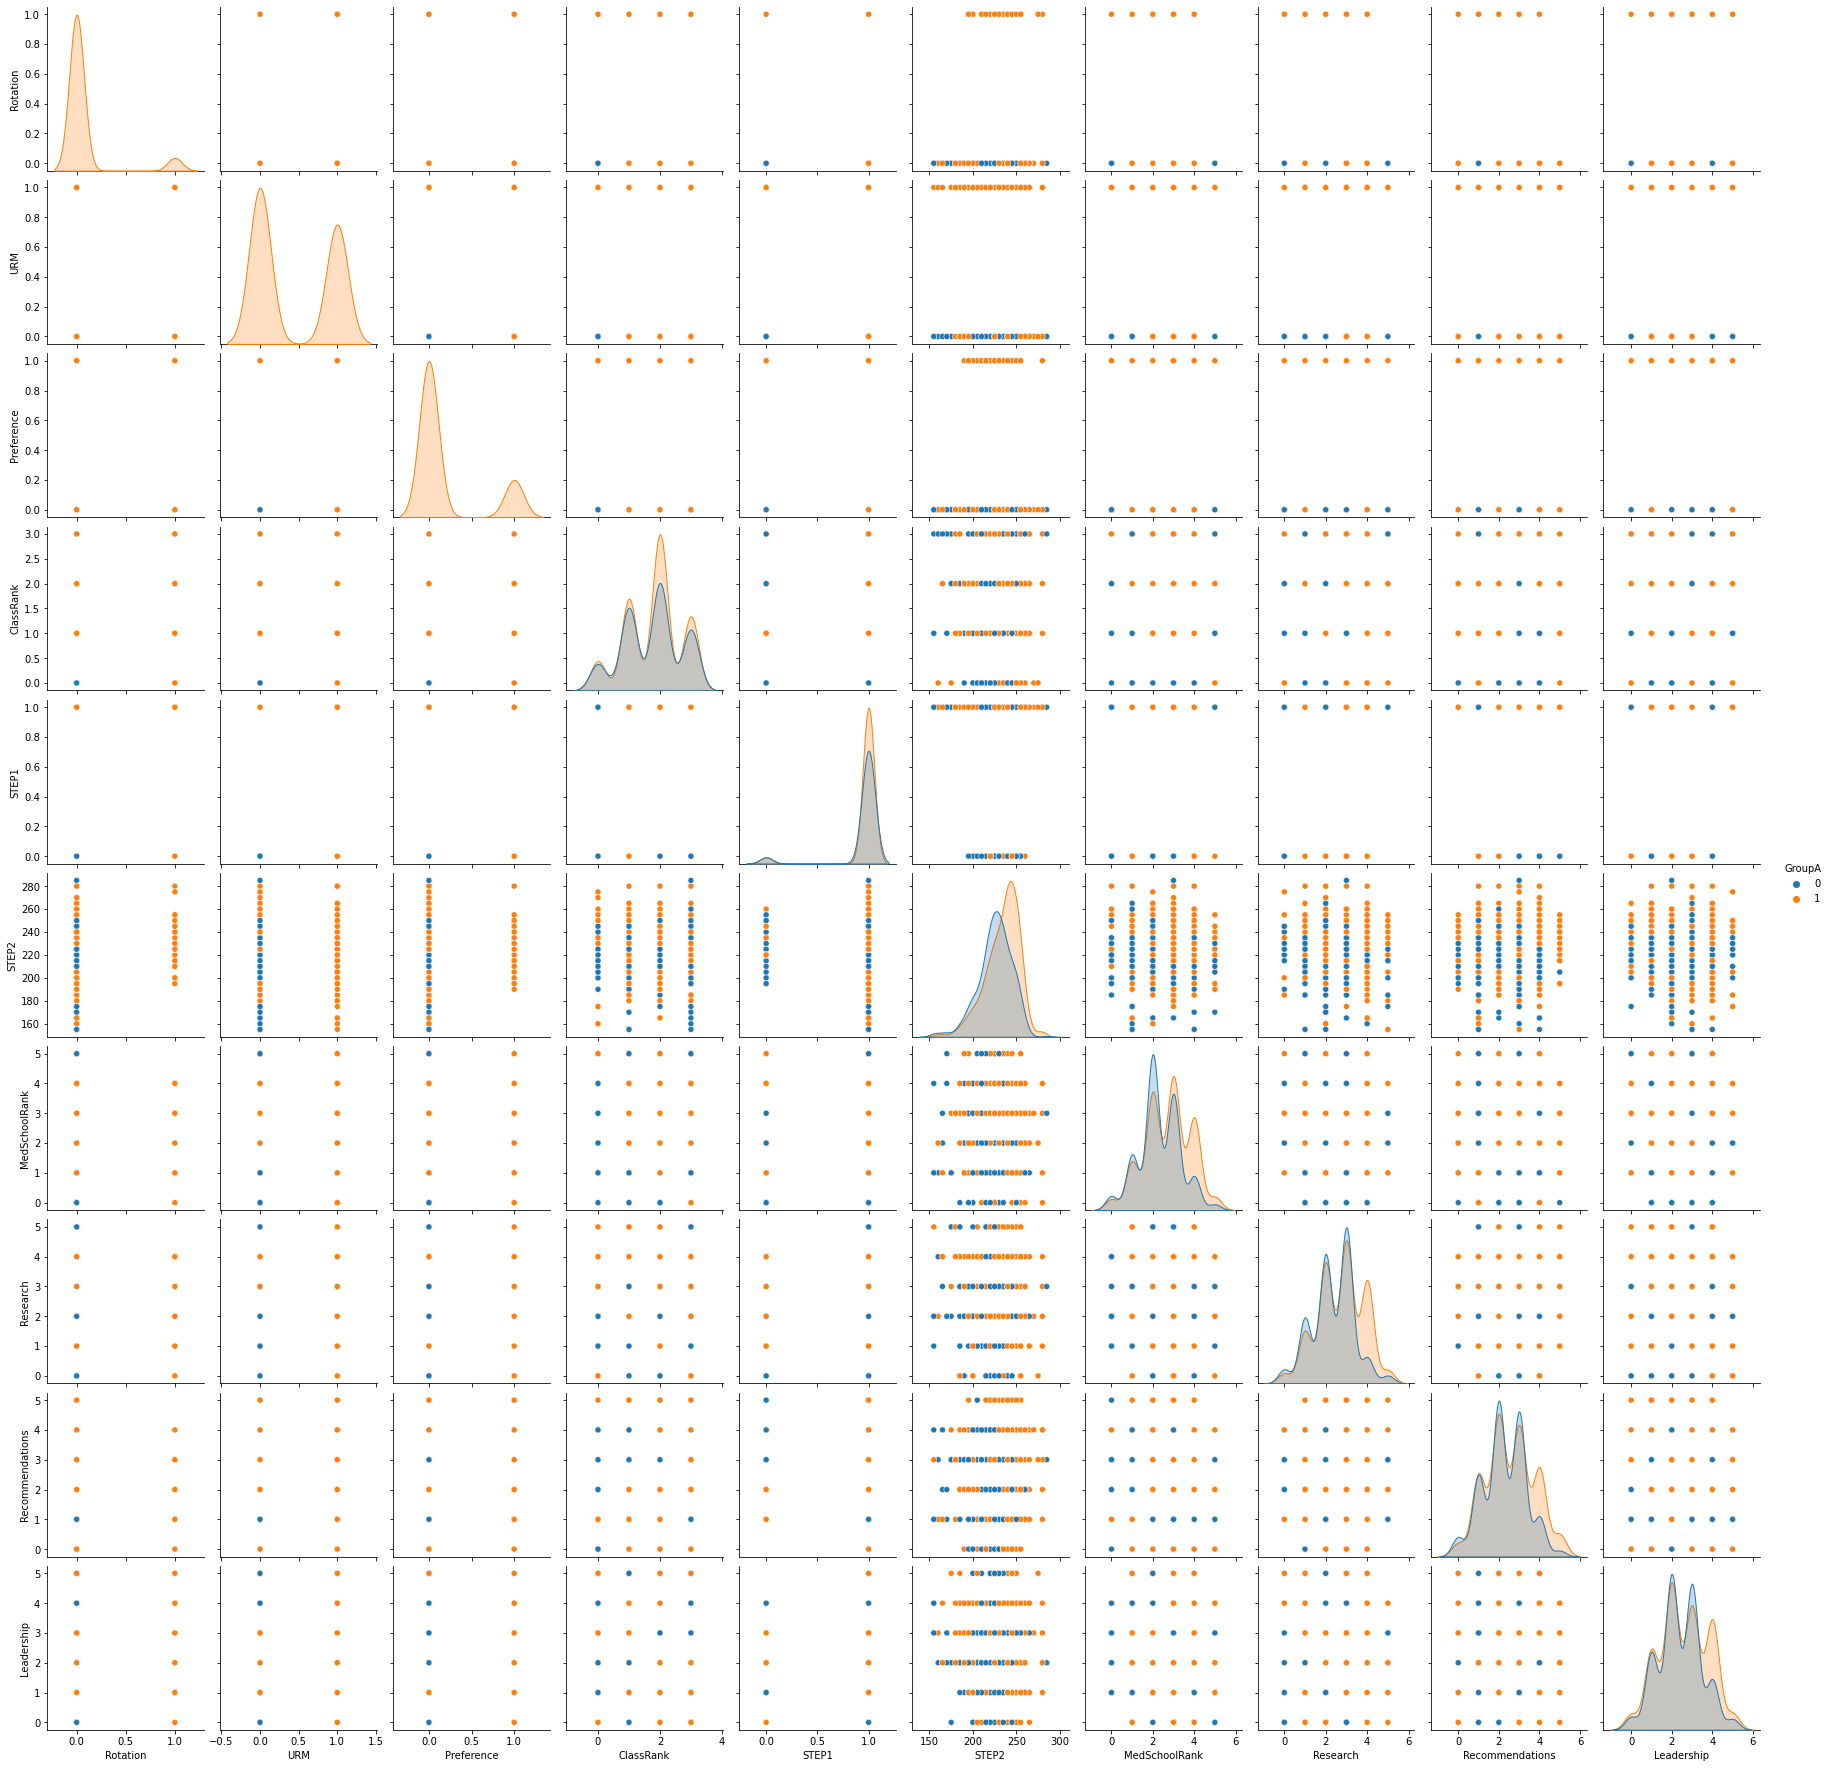

In [6]:
plt.figure()
sns.pairplot(applications, hue='GroupA')
plt.savefig('residency_pairplot.pdf')
plt.show()